In [47]:
#General imports
import math
import numpy as np
import time
from operator import itemgetter
import scipy.cluster.hierarchy as hcluster #for clustering ball positions
from collections import Counter
from bisect import bisect_left #For organizing timestamps

#Imports from ros and opencv
import rospy
import cv2
from sensor_msgs.msg import Image
from aruco_msgs.msg import MarkerArray
from cv_bridge import CvBridge, CvBridgeError
from geometry_msgs.msg import Twist
from nav_msgs.msg import Odometry
from std_msgs.msg import String

#Imports for plotting
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
%matplotlib inline

#Initializing global variables and classes
bridge = CvBridge()
rospy.init_node('turtlebot_singleplayer', anonymous=True)
rospy.sleep(0.5)
lower_blue = (0,0,120)
upper_blue = (100,100,255)
lower_red = (200,0,0)
upper_red = (255,100,100)

###################
#Callback functions
###################
def callback_color(msg):
    global color_timestamp
    global color_img
    color_timestamp = msg.header.stamp
    color_img = bridge.imgmsg_to_cv2(msg, "rgb8")

def callback_depth(msg):
    global depth_img
    global depth_timestamp
    depth_timestamp = msg.header.stamp
    depth_img = bridge.imgmsg_to_cv2(msg, "32FC1")

def callback_odom(data):
    global x
    global y
    global theta
    global odom_timestamp 
    position = data.pose.pose.position
    orientation = data.pose.pose.orientation
    odom_timestamp = data.header.stamp
    x = round(position.x, 3)
    y = round(position.y, 3)
    theta = round(2*math.atan2(orientation.z,orientation.w), 3)
    if theta<0:
        theta = 2*math.pi + theta

def callback_array(msg):
    global marker_array
    global marker_array_timestamp
    marker_array_timestamp = msg.header.stamp
    marker_array = msg.markers
    #print "Marker array:",marker_array_timestamp

def callback_state(msg):
    global dist2_balls 
    global dist2_gate
    global theta2_dif
    global state2
    state_dict = msg.data
    if(state_dict[0] == 's '):
        state2 = state_dict[2:]
    elif state_dict:
        state_dict = eval(state_dict)
        dist2_balls = state_dict['dist_balls']
        dist2_gate = state_dict['dist_gate']
        theta2_dif = state_dict['theta_dif']
##########################
#Functions used in general
##########################

#turn to certain theta
def turnToTheta(theta_tar):
    
    #Checking theta value
    if theta_tar < 0:
        theta_tar += math.pi *2
    if theta_tar > math.pi*2:
        theta_tar -= math.pi *2
        
    twist = Twist()
    twist.linear.x = 0.0
    ang_diff = theta_tar - theta
    s = np.sign(ang_diff)
    if abs(ang_diff) > math.pi:
        s *= -1.0
        ang_diff = 2*math.pi - abs(ang_diff)
    ang_vel = s*ang_diff*0.6
    if abs(ang_vel) < 0.2:
        ang_vel = np.sign(ang_vel)*0.2
    twist.angular.z = ang_vel
    r = rospy.Rate(10)
    while(abs(theta_tar-theta) > 0.1):
        publisher.publish(twist)
        r.sleep()
        ang_diff = abs(theta_tar - theta)
        if ang_diff > math.pi:
            ang_diff = 2*math.pi - ang_diff
        ang_vel = s*ang_diff*0.6
        if abs(ang_vel) < 0.2:
            ang_vel = np.sign(ang_vel)*0.2
        twist.angular.z = ang_vel
        #print theta

def moveForward(distance):
    #calibrate
    distance = (distance - 0.14)/0.85
    t = int(round(distance*25))
    twist = Twist()
    twist.linear.x = 0.4
    twist.angular.z = 0.0
    r = rospy.Rate(10)
    for i in range(t):
        publisher.publish(twist)
        r.sleep()
        
def kickForward():
    #Get balldistance again
    colorim = color_img.copy()
    depthim = depth_img.copy()
    x_ball, y_ball, distance = get_depth(colorim,depthim)
    #this is not calibrated, just a feeling the 0,6
    distance = (distance - 0.14)/0.85 *0.4
    t = int(round(distance*25))
    twist = Twist()
    twist.linear.x = 1.6
    twist.angular.z = 0.0
    r = rospy.Rate(10)
    for i in range(t):
        publisher.publish(twist)
        r.sleep()

def kickPosition(theta_target, dist_target, theta_second, dist_second, Pass):
    dist_BT = 0.5
    ang_GRB = abs(theta_target - theta_second)
    if ang_GRB > math.pi:
        ang_GRB = 2*math.pi - ang_GRB
    dist_RB = dist_second
    dist_RG = dist_target
    dist_BG = math.sqrt(pow(dist_RG,2) + pow(dist_RB,2) - 2*dist_RG*dist_RB*math.cos(ang_GRB))
    ang_GBR = math.acos((pow(dist_BG,2) + pow(dist_RB,2) - pow(dist_RG,2)) / (2*dist_BG*dist_RB))
    ang_RBT = math.pi - ang_GBR
    dist_RT = math.sqrt(pow(dist_RB,2) + pow(dist_BT,2) - 2*dist_RB*dist_BT*math.cos(ang_RBT))
    ang_BRT = math.acos((pow(dist_RB,2) + pow(dist_RT,2) - pow(dist_BT,2)) / (2*dist_RB*dist_RT))
    ang_BTR = math.acos((pow(dist_BT,2) + pow(dist_RT,2) - pow(dist_RB,2)) / (2*dist_BT*dist_RT))
    ang_back = math.pi - ang_BTR
    if abs(theta_target - theta_second) > math.pi: # 0-2pi condition
        if Pass !=(theta_second > theta_target):
            theta_move = theta_second - ang_BRT
            theta_back = theta_move + ang_back
        else:
            theta_move = theta_second + ang_BRT
            theta_back = theta_move - ang_back
    else:
        if Pass != (theta_second < theta_target):
            theta_move = theta_second - ang_BRT
            theta_back = theta_move + ang_back
        else:                          
            theta_move = theta_second + ang_BRT
            theta_back = theta_move - ang_back
    return theta_move, dist_RT, theta_back

#Given color and depth image calculate the depth point, and middle points of ball
def get_depth(colorim,depthim):
    mask_blue = cv2.inRange(colorim, lower_blue, upper_blue)
    mask_red = cv2.inRange(colorim, lower_red, upper_red)
    kernel = np.ones((5,5),np.uint8)
    erosion_blue = cv2.erode(mask_blue,kernel,iterations = 1)
    dilation_blue = cv2.dilate(erosion_blue,kernel,iterations = 3)
    erosion_red = cv2.erode(mask_red,kernel,iterations = 1)
    dilation_red = cv2.dilate(erosion_red,kernel,iterations = 3)
    mask = cv2.bitwise_or(dilation_blue, dilation_red)
    im, cnt, hrc = cv2.findContours(mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnt.sort(key=cv2.contourArea, reverse=True)
    if cnt:
        x, y, w, h = cv2.boundingRect( cnt[0] )
        if (w*h > 2000):
            x_ball = x+w/2
            y_ball = y+h/2
            dist_ball = np.nanmedian(depthim[y:y+h,x:x+w])
        else:
            x_ball = 0
            y_ball = 0
            dist_ball = None
    else:
        x_ball = 0
        y_ball = 0
        dist_ball = None
    return x_ball,y_ball,dist_ball

#For organizing measurements by timestamp
def takeClosest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
       return after
    else:
       return before


#Subscribers and Publishers
subscriber = rospy.Subscriber("odom", Odometry, callback_odom)
publisher = rospy.Publisher('cmd_vel_mux/input/teleop', Twist, queue_size=10)

#Subscriber publisher to connect to the other
publisher_state = rospy.Publisher('/state', String, queue_size=1)
subscribe_state = rospy.Subscriber('/bestRobot/state', String, callback_state)

In [48]:
def otherRobotDiagnostic(xb, yb,dist2_balls,xg, yg,dist2_gate,points_x, points_y):
    circle1 = plt.Circle((xb, yb), dist2_balls, color='r', fill=False)
    circle2 = plt.Circle((xg, yg), dist2_gate, color='blue', fill=False)
    

    fig, ax = plt.subplots() 
    ax.add_artist(circle1)
    ax.add_artist(circle2)
    ax.plot(points_x, points_y, marker='o', markersize=3, color="red")
    
    ax.set_xlim([-5,5])
    ax.set_ylim([-5,5])

    plt.show()
    
def calculateOtherPosition(theta_ball,dist_balls,theta_gate,dist_gate,
                          dist2_balls,dist2_gate,theta2_dif):
    #Theta dif: difference between the theta of the (theta_ball-theta_gate)
    global theta2,dist2,theta3,dist3
    #Go to Cartesian coordinates
    x0 = math.cos(theta_ball) * dist_balls
    y0 = math.sin(theta_ball) * dist_balls
    x1 = math.cos(theta_gate) * dist_gate
    y1 = math.sin(theta_gate) * dist_gate
    
    vec = np.array([[x0,y0,dist2_balls],[x1,y1,dist2_gate]])
    vec[vec[:,2].argsort()]
    difference_vec = vec[0,:2]-vec[1,:2]
    center_dist = np.linalg.norm(difference_vec)
    difference_vec = difference_vec/center_dist

    if(vec[1,2]> vec[0,2] + center_dist):
        #Circle is inside another circle
        p1 = difference_vec*vec[0,2] + np.array([x0,y0])
        p2 = difference_vec*vec[1,2] + np.array([x1,y1])
        p = (p1+p2)/2
        theta = math.atan2(p[1],p[0])
        if theta < 0:
            theta += math.pi*2
        dist = math.sqrt(p[1]**2 + p[0]**2)
        print "Circles inside each other"
        otherRobotDiagnostic(x0, y0,dist2_balls,x1, y1,dist2_gate,[p1[0],p2[0],p[0]], [p1[1],p2[1],p[1]])
        return dist,theta
    elif(center_dist> vec[0,2] + vec[1,2]):
        #Two circles do not intersect
        difference_vec = np.array([x1-x0,y1-y0])
        difference_vec = difference_vec / np.linalg.norm(difference_vec)
        p1 = difference_vec*vec[0,2] + np.array([x0,y0])
        p2 = -1* difference_vec*vec[1,2] + np.array([x1,y1])
        p = (p1+p2)/2
        theta = math.atan2(p[1],p[0])
        if theta < 0:
            theta += math.pi*2
        dist = math.sqrt(p[1]**2 + p[0]**2)
        print "Circles do not touch"
        otherRobotDiagnostic(x0, y0,dist2_balls,x1, y1,dist2_gate,[p1[0],p2[0],p[0]], [p1[1],p2[1],p[1]])
        return dist,theta
    else:
        #Caluclate the two points
        d=math.sqrt((x1-x0)**2 + (y1-y0)**2)
        a=(dist2_balls**2-dist2_gate**2+d**2)/(2*d)
        h=math.sqrt(dist2_balls**2-a**2)

        p2_x =x0+a*(x1-x0)/d   
        p2_y =y0+a*(y1-y0)/d   

        x2 = p2_x + h * (y1 - y0) / d
        y2 = p2_y - h * (x1 - x0) / d

        #Calculate theta2_dif according to the first option
        x0_0 = x0 - x2
        y0_0 = y0 - y2 
        x1_0 = x1 - x2
        y1_0 = y1 - y2
        theta0_0 = math.atan2(y0_0,x0_0)
        if theta0_0 < 0:
            theta0_0 += 2*math.pi
        dist0_0 = math.sqrt(x0_0**2+y0_0**2)
        theta1_0 = math.atan2(y1_0,x1_0)
        if theta1_0 < 0:
            theta1_0 += 2*math.pi
        dist1_0 = math.sqrt(x1_0**2+y1_0**2)
        theta20_dif = theta1_0-theta0_0
        if(theta20_dif<0):
            theta20_dif += math.pi*2

        theta2 = math.atan2(y2,x2)
        if(theta2<0):
            theta2 += math.pi*2
        dist2 = math.sqrt(x2**2+y2**2)

        #Check the other point
        x3=p2_x - h*(y1-y0)/d       
        y3=p2_y + h*(x1-x0)/d 

        x0_1 = x0 - x3
        y0_1 = y0 - y3 
        x1_1 = x1 - x3
        y1_1 = y1 - y3
        theta0_1 = math.atan2(y0_1,x0_1)
        if theta0_1 < 0:
            theta0_1 += 2*math.pi
        dist0_1 = math.sqrt(x0_1**2+y0_1**2)
        theta1_1 = math.atan2(y1_1,x1_1)
        if theta1_1 < 0:
            theta1_1 += 2*math.pi
        dist1_1 = math.sqrt(x1_1**2+y1_1**2)
        theta3_dif = theta1_1-theta0_1
        if(theta3_dif<0):
            theta3_dif += math.pi*2

        theta3 = math.atan2(y3,x3)
        if(theta3<0):
            theta3 += math.pi*2
        dist3 = math.sqrt(x3**2+y3**2)
        
        otherRobotDiagnostic(x0, y0,dist2_balls,x1, y1,dist2_gate,[x2,x3], [y2,y3])
        print "Circles intersect"
        if((abs(theta3_dif-theta2_dif))<(abs(theta20_dif-theta2_dif))):
            return theta3,dist3
        else:
            return theta2,dist2

In [49]:
#################
#Finding the gate
#################
def findGate(a=1,b=0):
    #Calibration coefficients a and b
    # y = a*x + b
    #White robot: a=1.08,b=0.03
    #Red robot: a=1.13,b=0.02
    #To access variables from the callbacks we neeed to define them inside as globals
    global theta, marker_array
    
    
    subscriber_array = rospy.Subscriber("/aruco_marker_publisher/markers", MarkerArray, callback_array)
    publisher_state.publish("s measuring")

    gate_dist, gate_stamp, gate_theta, gate_theta_raw, gate_theta_stamp = [],[],[],[],[] # Whether it was found, and its theta coordinate, and x 
    twist = Twist()
    #We need this if we want to turn full circle
    theta_initial = theta
    theta_opposite = math.atan2(-math.sin(theta_initial),-math.cos(theta_initial))
    if theta_opposite < 0:
        theta_opposite += 2* math.pi
    half_circle = False

    #For data storage
    marker_array = None
    m = None
    #Turn around and save data
    while (abs(theta-theta_initial)>0.1 or (half_circle != True)):
        if(abs(theta-theta_opposite)<0.1):
            half_circle = True
        twist.angular.z = 0.2


        r = rospy.Rate(100)
        for i in range(10):
            publisher.publish(twist)
            r.sleep()

        gate_theta_raw.append(theta)
        gate_theta_stamp.append(odom_timestamp)
        try:
            m = marker_array[0]
            dist = math.sqrt(m.pose.pose.position.x**2+m.pose.pose.position.z**2)
            dist = dist * a + b
            gate_dist.append(dist)
            gate_stamp.append(marker_array_timestamp)
            marker_array = None
        except TypeError:
            pass

    #Organizing timestamps
    for stamp in gate_stamp:
        index = gate_theta_stamp.index(takeClosest(gate_theta_stamp, stamp))
        gate_theta.append(gate_theta_raw[index])

    #Theta cleanup in (x,y) space
    x_ = np.cos(gate_theta)
    y_ = np.sin(gate_theta)
    theta_gate = math.atan2(np.mean(y_),np.mean(x_))
    if theta_gate < 0:
        theta_gate += 2*math.pi
    #Distance cleanup
    sd = np.std(gate_dist)
    mean = np.mean(gate_dist)
    final_list = [x for x in gate_dist if (x > mean - sd)]
    final_list = [x for x in final_list if (x < mean +  sd)]
    dist_gate = np.mean(final_list)
    
    subscriber_array.unregister()
    return dist_gate, theta_gate, gate_theta, gate_dist


In [50]:
#################
#Finding the ball
#################
def findBall(a=1,b=0):
    #Calibration coefficients a and b
    # y = a*x + b
    #White robot: a=0.97,b=0.1
    #Red robot: a=1.01,b=0.07
    #To access variables from the callbacks we neeed to define them inside as globals
    global theta, color_img, depth_img
    
    
    subscriber_color = rospy.Subscriber("/camera/rgb/image_rect_color", Image, callback_color)
    subscriber_depth = rospy.Subscriber("/camera/depth/image_rect", Image, callback_depth)
    
    twist = Twist()
    #We need this if we want to turn full circle
    theta_initial = theta
    theta_opposite = math.atan2(-math.sin(theta_initial),-math.cos(theta_initial))
    if theta_opposite < 0:
        theta_opposite += 2* math.pi
    half_circle = False

    ball_pos = []
    #Turn around
    while (abs(theta-theta_initial)>0.1 or (half_circle != True)):
        if(abs(theta-theta_opposite)<0.1):
            half_circle = True

        twist.angular.z = 0.2
        r = rospy.Rate(100)
        for i in range(5):
            publisher.publish(twist)
            r.sleep()
        theta_cur = theta
        colorim = color_img.copy()
        depthim = depth_img.copy()
        x_ball, y_ball, dist_ball = get_depth(colorim,depthim)

        if dist_ball:
            dist_ball = dist_ball *a + b
            ball_pos.append([x_ball, y_ball, theta_cur, dist_ball])

    #Cleanup theta
    ball_np = np.array(ball_pos)
    #Remove nan values
    ball_np = ball_np[~np.isnan(ball_np).any(axis=1)]
    #Go to sin and cos space from angle
    ball_temp = np.empty([ball_np.shape[0],4])
    ball_temp[:,0] = np.sin(ball_np[:,2])
    ball_temp[:,1] = np.cos(ball_np[:,2])
    ball_temp[:,2] = ball_np[:,3]
    ball_temp[:,3] = ball_np[:,2]
    #Do the clustering
    thresh = 0.2
    clusters = hcluster.fclusterdata(ball_temp, thresh, criterion="distance")
    #Separate clusters
    b = Counter(clusters)
    label = b.most_common(1)[0][0]
    theta_cleaned = []
    for ind,cl in enumerate(clusters):
        if cl == label:
            theta_cleaned.append([ball_temp[ind,0],ball_temp[ind,1],ball_temp[ind,2],ball_temp[ind,3]])
    #Caluclate average theta
    theta_ball = math.atan2(np.mean(np.array(theta_cleaned)[:,0]),np.mean(np.array(theta_cleaned)[:,1]))
    if theta_ball < 0:
        theta_ball += 2*math.pi
    dist_balls = np.mean(np.array(theta_cleaned)[:,2])
    
    #Plotin the theta and distance values for the ball
    plt.scatter(ball_np[:,2],ball_np[:,3],c=clusters,s=500,marker='o')
    plt.title("Ball Position Clusters")
    plt.xlabel("Theta Angle [rad]")
    plt.ylabel("Ball Distance [m]")
    plt.show()
    
    subscriber_color.unregister()
    subscriber_depth.unregister()
    return dist_balls, theta_ball, ball_np, theta_cleaned


In [51]:
#Publish the data which was acquired
def locateOtherRobot():
    theta_dif = theta_gate-theta_ball
    if(theta_dif<0):
        theta_dif += math.pi*2
    state_dict = {'dist_balls':dist_balls,'dist_gate':dist_gate,'theta_dif':theta_dif,'recieved':False}
    while(state_dict['recieved'] == False):
        try:
            if(dist2_balls):
                state_dict['recieved'] = True
        except NameError:
            pass
        publisher_state.publish(str(state_dict))
        rospy.sleep(0.5)
    theta2, dist2 = calculateOtherPosition(theta_ball,dist_balls,theta_gate,dist_gate,
                              dist2_balls,dist2_gate,theta2_dif)
    return theta2, dist2

In [52]:
##################
#Diagnostic figure
##################
def diagnosticFigure():
    plt.figure(figsize=(10, 10))
    ax = plt.axes(polar=True)
    max_val = math.ceil(max(dist_balls, dist_gate,max(np.nan_to_num(ball_np[:,3])),max(gate_dist) ))
    handle = []

    #Plot robot
    ax.plot(0, 0,marker='o',markersize=20)
    ax.text( s =r'TURTLEBOT',x=0,y=0, horizontalalignment='center',
            verticalalignment='center')
    handle.append(mlines.Line2D([], [], color='blue', marker='o',
                              markersize=15, label='Robot Position'))


    #PlotGate
    try:
        ax.plot(theta_gate,dist_gate,marker='o',markersize=20)
        ax.text( s =r'GATE',x=theta_gate,y=dist_gate, horizontalalignment='center',
                verticalalignment='center')
        handle.append(mlines.Line2D([], [], color='green', marker='o',
                              markersize=15, label='Gate Position'))
    except:
        pass
    #Plot robot2
    try:
        ax.plot(theta2, dist2,marker='o',markersize=20)
        ax.text( s =r'OTHERBOT',x=0,y=0, horizontalalignment='center',
                verticalalignment='center')
        handle.append(mlines.Line2D([], [], color='blue', marker='o',
                                  markersize=15, label='Best Position'))
    except:
        pass

    #PlotBall
    try:
        ax.plot(theta_ball,dist_balls,marker='o',markersize=20)
        ax.text( s =r'BALL',x=theta_ball, y=dist_balls, horizontalalignment='center',
                verticalalignment='center')
        handle.append(mlines.Line2D([], [], color='red', marker='o',
                              markersize=15, label='Ball Position'))
    except:
        pass

    #Data points of ball
    try:
        y_ball = np.nan_to_num(ball_np[:,3])+np.isnan(ball_np[:,3])*(max_val*0.8)
        ax.plot(ball_np[:,2],y_ball,marker='D',markersize=5,c='purple')
        handle.append(mlines.Line2D([], [], color='purple', marker='D',
                              markersize=15, label='Ball Measurements'))
        ax.plot(np.array(theta_cleaned)[:,3],np.array(theta_cleaned)[:,2],marker='s',markersize=5,c='orange')
        handle.append(mlines.Line2D([], [], color='orange', marker='s',
                              markersize=15, label='Ball Filtered'))
    except:
        pass

    #Data points of gate
    try:
        ax.plot(gate_theta,gate_dist,marker='o',markersize=5,c='gray')
        handle.append(mlines.Line2D([], [], color='gray', marker='o',
                              markersize=15, label='Gate Measurements'))
    except:
        pass


    #ax.set_rmax(max_val)
    #ax.set_rlabel_position(0)  # get radial labels away from plotted line
    ax.grid(True)

    ax.set_title("Objects around the TURTLEBOT", va='bottom')
    xL = [0,0.25,0.5,0.75,1,1.25,1.5,1.75]
    xL = [round(math.pi*x,2) for x in xL]
    ax.set_xticklabels(xL, fontdict=None, minor=False)
    plt.legend(handles=handle)

    plt.show()

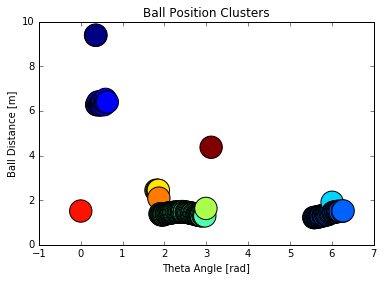

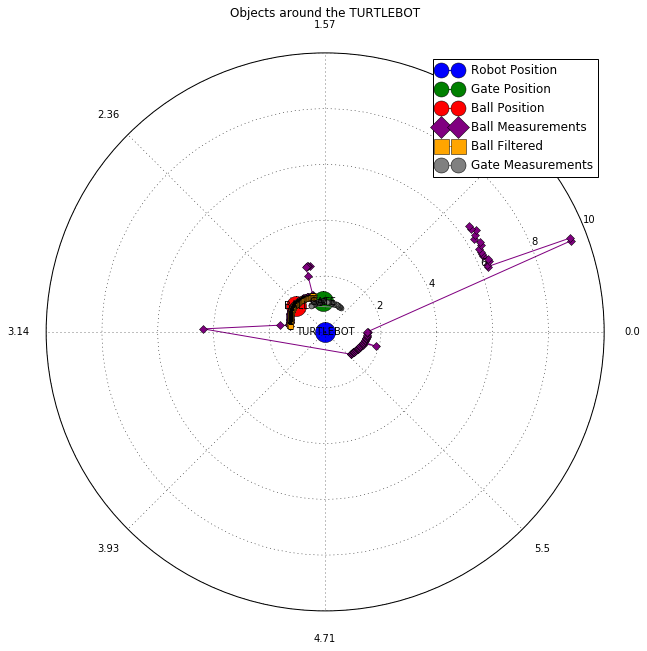

In [53]:
dist_gate, theta_gate, gate_theta, gate_dist = findGate(a=1.08,b=0.03)
dist_balls, theta_ball, ball_np, theta_cleaned = findBall(a=0.97,b=0.1)
#theta2, dist2 = locateOtherRobot()
diagnosticFigure()

In [ ]:
if(dist_balls<dist2_balls):
    #Pass the ball to teammate
    publisher_state.publish("s passing")
    theta_middle, dist_middle, theta_nouse = kickPosition(theta_gate, dist_gate, theta2, dist2, True)
    theta_tar, dist_tar, theta_back = kickPosition(theta_middle, dist_middle, theta_ball, dist_balls, False)
    turnToTheta(theta_tar)
    moveForward(dist_tar)
    turnToTheta(theta_back)
    kickForward()
    rospy.sleep(5)
    publisher_state.publish("s done")

In [120]:
theta_tar, dist_tar, theta_back

(4.424838283084276, 0.6902724533676652, 2.6655205780543367)

In [20]:
#move to the target position
theta_tar, dist_RT, theta_back = kickPosition(theta_gate, dist_gate, theta_ball, dist_balls, False)
turnToTheta(theta_tar)
moveForward(dist_RT)

turnToTheta(theta_back)

#Get gate distance
rospy.sleep(0.5)
m = marker_array[0]
goal_dist = math.sqrt(m.pose.pose.position.x**2+m.pose.pose.position.z**2)
goal_dist = (goal_dist-0.2) * 1.08 + 0.03 #we stop 15 cm ahead so it wont hit the gate
moveForward(goal_dist) 